# Подготовка

In [15]:
from itertools import product as prod
from pprint import pprint
# from time import sleep
from typing import TypeVar, Collection, Any, Sequence
# from IPython.display import Image, display, HTML, clear_output
import base64
# import numpy as np
import pandas as pd
import pygraphviz as pgv

In [17]:
State = TypeVar('State')
NewState = TypeVar('NewState')
Input = TypeVar('Input')
Output = TypeVar('Output')
Any1 = Any
Any2 = Any
StateMachine = TypeVar('StateMachine')
_dummy_graph_for_empty_node = pgv.AGraph()
_dummy_graph_for_empty_node.add_node("EMPTY", shape="none", label="")
EMPTY_NODE = pgv.Node(_dummy_graph_for_empty_node, "EMPTY")
abc = 'ABCDEFGHIJKLMNOPQRSTUVWXYZБГДЁЖЗИЙЛУФЦЧШЩЪЫЬЭЮЯ'
_CRUTCH = "-"

In [8]:
def draw(
    *graphs: pgv.AGraph | StateMachine,
    width=200,
    labels=None,
    prog='dot'
):
    """https://stackoverflow.com/a/40494608 and DeepSeek"""

    html_content = "<div style = 'display: flex; flex-wrap: wrap; gap: 20px;'>"
    labels = labels or list(range(len(graphs)))
    for i, graph in enumerate(graphs):
        if not isinstance(graph, pgv.AGraph):
            graph = graph.get_graph()
        img_b64 = base64.b64encode(
            graph.draw(format='png', prog=prog)
        ).decode()
        img_src = f"data:image/png;base64,{img_b64}"
        html_content += f"""
<div style = 'text-align: center;'>
    <img src = '{img_src}' width = '{width}' style = 'border: 1px solid #ccc;'>
    <div><strong>{labels[i]}</strong></div>
</div>
"""
    html_content += "</div>"
    display(HTML(html_content))

In [12]:
def reverse_dict_of_collection(
    d: dict[Any1, Collection[Any2]]
) -> dict[Any2, Any1]:
    return {v: k for k, setOfV in d.items() for v in setOfV}


def to_str_or_pair(value):
    if type(value) is Pair:
        return value
    return str(value)

In [13]:
class Pair:
    """Пара элементов. Нужно для сравнения автоматов на эквивалентность."""

    def __init__(self, a, b):
        self.a = a
        self.b = b

    def __lt__(self, other):
        return self.a < other.a or self.b < other.b

    def __str__(self):
        return f'({self.a}, {self.b})'

    def __repr__(self):
        return f'({self.a}, {self.b})'

    def __bool__(self):
        return bool(self.a == self.b)

    def __eq__(self, other):

        if not isinstance(other, Pair):
            return False

        return (self.a, self.b) == (other.a, other.b)

    def __hash__(self):
        return hash((self.a, self.b))


# Автоматы

In [16]:
class MealyStateMachine:

    def __init__(self,
                 in_abc: Collection[Input],
                 out_abc: Collection[Output],
                 state_abc: Collection[State],
                 l_func: dict[(State, Input), Output],
                 d_func: dict[(State, Input), State],
                 start_state: State):

        self.in_abc = tuple(map(to_str_or_pair, sorted(set(in_abc))))
        self.out_abc = tuple(map(to_str_or_pair, sorted(set(out_abc))))
        self.state_abc = tuple(map(to_str_or_pair, sorted(set(state_abc))))
        self.l_func = {
            (to_str_or_pair(k1), to_str_or_pair(k2)): to_str_or_pair(v)
            for (k1, k2), v in l_func.items()
        }
        self.d_func = {
            (to_str_or_pair(k1), to_str_or_pair(k2)): to_str_or_pair(v)
            for (k1, k2), v in d_func.items()
        }
        self.current_state = self.start_state = to_str_or_pair(start_state)
        assert self.start_state in self.state_abc
        for (s, i), o in self.l_func.items():
            assert s in self.state_abc
            assert i in self.in_abc
            assert o in self.out_abc
        for (s1, i), s2 in self.d_func.items():
            assert s1 in self.state_abc
            assert s2 in self.state_abc
            assert i in self.in_abc
        self.table = None

    def get_table(self) -> pd.DataFrame:
        if self.table is None:
            index = pd.Index(sorted(self.state_abc), name='states')
            columns = list()
            data = dict()
            for label, letter in prod('ld', self.in_abc):
                columns.append((label, letter))
                data.setdefault((label, letter), dict())
            columns = pd.MultiIndex.from_tuples(columns)
            for letter, state in prod(self.in_abc, self.state_abc):
                data['l', letter][state] = self.l_func[state, letter]
                data['d', letter][state] = self.d_func[state, letter]
            self.table = pd.DataFrame(data=data, index=index, columns=columns)
        return self.table

    def get_graph(self) -> pgv.AGraph:
        graph = pgv.AGraph(strict=False, directed=True)
        graph.add_node(EMPTY_NODE, **EMPTY_NODE.attr)
        graph.add_nodes_from(self.state_abc, color="black", shape="circle")
        graph.add_node(self.current_state, color="red", shape="circle")
        graph.add_edge(EMPTY_NODE, self.start_state)
        for state, inp in prod(self.state_abc, self.in_abc):
            destination = self.d_func[state, inp]
            output = self.l_func[state, inp]
            label = f"{inp}/{output}"
            graph.add_edge(state, destination, label=label)
        return graph

    def step(self, input) -> (State, Output):
        self.current_state, output = \
            self.d_func[self.current_state, input], \
            self.l_func[self.current_state, input]
        return self.current_state, output

    def restart(self):
        self.current_state = self.start_state

    def full_output(
        self, input: Collection[Input]
    ) -> tuple[Sequence[State], Sequence[Output]]:
        self.restart()
        output, state = list(), list()
        for inp in input:
            s, o = self.step(inp)
            output.append(o)
            state.append(s)
        return tuple(state), tuple(output)

    def get_minimizer(self) -> "MealyStateMachineMinimizer":
        return MealyStateMachineMinimizer(self)

    def to_moore(self) -> "MooreStateMachine":
        state_and_outputs: dict[State, list[Output]] = dict()
        # old_states_and_new_states_with_outputs
        os_a_nswo: dict[State, list[(NewState, Output)]] = dict()
        fused_l_d_func: dict[(State, Input), (State, Output, NewState)] = dict()

        new_d_func: dict[(NewState, Input), NewState] = dict()
        new_l_func: dict[NewState, Output] = dict()

        for (source_state, input), dist_state in self.d_func.items():
            state_and_outputs.setdefault(dist_state, list())
            os_a_nswo.setdefault(dist_state, list())

            output = self.l_func[source_state, input]
            if output not in state_and_outputs[dist_state]:
                state_and_outputs[dist_state].append(output)

            new_state = str(dist_state) + \
                state_and_outputs[dist_state].index(output) * '`'
            if (new_state, output) not in os_a_nswo[dist_state]:
                os_a_nswo[dist_state].append((new_state, output))

            fused_l_d_func[source_state, input] = \
                (dist_state, output, new_state)
            new_l_func[new_state] = output

        for (old_source_state, input) in fused_l_d_func:
            _, _, new_dist_state = fused_l_d_func[old_source_state, input]
            for new_source_state, _ in os_a_nswo[old_source_state]:
                new_d_func[new_source_state, input] = new_dist_state

        return MooreStateMachine(
            in_abc=self.in_abc,
            out_abc=self.out_abc,
            state_abc=set(state for state, _ in new_l_func.items()),
            d_func=new_d_func,
            l_func=new_l_func,
            start_state=self.start_state
        )

    def __or__(self, other) -> "MealyStateMachine":
        if not isinstance(other, MealyStateMachine):
            raise TypeError("other must be MealyStateMachine")
        if self.in_abc != other.in_abc:
            raise SyntaxError("lalala")
        if self.out_abc != other.out_abc:
            raise SyntaxError("lalala")
        out_abc = list(Pair(a, b) for a, b in prod(self.out_abc, other.out_abc))

        start_state = Pair(self.start_state, other.start_state)
        l_func = dict()
        d_func = dict()
        total_states = [start_state]
        for state in total_states:
            for inp in self.in_abc:
                l_func[state, inp] =\
                    Pair(self.l_func[state.a, inp],\
                         other.l_func[state.b, inp])
                new_state =\
                    Pair(self.d_func[state.a, inp],\
                         other.d_func[state.b, inp])
                d_func[state, inp] = new_state
                if new_state not in total_states:
                    total_states.append(new_state)

        return MealyStateMachine(
            self.in_abc,
            out_abc,
            total_states,
            l_func=l_func,
            d_func=d_func,
            start_state=start_state
        )


In [31]:
class MooreStateMachine:

    def __init__(self,
                 in_abc: Collection[Input],
                 out_abc: Collection[Output],
                 state_abc: Collection[State],
                 l_func: dict[(State, ), Output],
                 d_func: dict[(State, Input), State],
                 start_state: State):

        self.in_abc = \
            tuple(map(to_str_or_pair, sorted(set(in_abc))))
        self.out_abc = \
            tuple(map(to_str_or_pair, sorted(set(out_abc))))
        self.state_abc = \
            tuple(map(to_str_or_pair, sorted(set(state_abc))))
        self.l_func = {
            (to_str_or_pair(k), _CRUTCH): to_str_or_pair(v)
            for k, v in l_func.items()
        }
        self.d_func = {
            (to_str_or_pair(k1), to_str_or_pair(k2)): to_str_or_pair(v)
            for (k1, k2), v in d_func.items()
        }
        self.current_state = self.start_state = to_str_or_pair(start_state)
        assert self.start_state in self.state_abc, \
            f"{self.start_state} not in {self.state_abc}"
        for (s, _), o in self.l_func.items():
            assert s in self.state_abc, f'{s} not in {self.state_abc}'
            assert o in self.out_abc, f'{o} not in {self.out_abc}'
        for (s1, i), s2 in self.d_func.items():
            assert s1 in self.state_abc, f'{s1} not in {self.state_abc}'
            assert s2 in self.state_abc, f'{s2} not in {self.state_abc}'
            assert i in self.in_abc, f'{i} not in {self.in_abc}'
        self.table = None

    def is_descriptor(self):
        return len(self.out_abc) == 2

    def get_table(self) -> pd.DataFrame:
        if self.table is None:
            index = pd.Index(sorted(self.state_abc), name='states')
            columns = list()
            data = dict()
            data.setdefault(('l', _CRUTCH), dict())
            for letter in self.in_abc:
                columns.append(('d', letter))
                data.setdefault(('d', letter), dict())
            columns.append(('l', _CRUTCH))
            columns = pd.MultiIndex.from_tuples(columns)
            for state in self.state_abc:
                data['l', _CRUTCH][state] = self.l_func[state, _CRUTCH]
                for letter in self.in_abc:
                    data['d', letter][state] = self.d_func[state, letter]
            self.table = pd.DataFrame(data=data, index=index, columns=columns)
        return self.table

    def get_graph(self, chosen_out=None) -> pgv.AGraph:
        yes = False
        if chosen_out is not None:
            assert self.is_descriptor(), f'is not descriptor'
            assert chosen_out in self.out_abc, \
                f'{chosen_out} not in {self.out_abc}'
            yes = True
        graph = pgv.AGraph(strict=False, directed=True)
        graph.add_node(EMPTY_NODE, **EMPTY_NODE.attr)
        for (state, _), out in self.l_func.items():
            label = f"{state}/{out}" if not yes else state
            shape = "doublecircle" if yes and out == chosen_out else "circle"
            graph.add_node(state, label=label, color="black", shape=shape)
        graph.add_node(self.current_state, color="red")
        penwidth = 2.0 \
            if self.l_func[self.start_state, _CRUTCH] == chosen_out \
            else 1.0
        graph.add_edge(EMPTY_NODE, self.start_state, penwidth=penwidth)
        for state, inp in prod(self.state_abc, self.in_abc):
            destination = self.d_func[state, inp]
            label = f"{inp}"
            penwidth = 2.0 \
                if self.l_func[destination, _CRUTCH] == chosen_out \
                else 1.0
            graph.add_edge(state, destination, label=label, penwidth=penwidth)
        return graph

    def step(self, input) -> (State, Output):
        self.current_state = self.d_func[self.current_state, input]
        output, = self.l_func[self.current_state]
        return self.current_state, output

    def restart(self):
        self.current_state = self.start_state

    def full_output(self, input: Collection[Input]) -> (tuple[State], tuple[Output]):
        self.restart()
        output, state = [self.l_func[self.current_state]], [self.current_state]
        for inp in input:
            s, o = self.step(inp)
            output.append(o)
            state.append(s)
        return tuple(state), tuple(output)

    def get_minimizer(self) -> "MooreStateMachineMinimizer":
        return MooreStateMachineMinimizer(self)

    def to_mealy(self) -> MealyStateMachine:
        l_func = dict()
        for (source_state, input), dist_state in self.d_func.items():
            output = self.l_func[dist_state, _CRUTCH]
            l_func[source_state, input] = output
        return MealyStateMachine(
            self.in_abc,
            self.out_abc,
            self.state_abc,
            l_func,
            self.d_func,
            self.start_state
        )

    ### REDO
    def __or__(self, other) -> "MooreStateMachine":
        if not isinstance(other, MooreStateMachine):
            raise TypeError("other must be MooreStateMachine")
        if self.in_abc != other.in_abc:
            raise SyntaxError("lalala")
        if self.out_abc != other.out_abc:
            raise SyntaxError("lalala")
        out_abc = \
            list(Pair(a, b) for a, b in prod(self.out_abc, other.out_abc))

        start_state = Pair(self.start_state, other.start_state)
        l_func = dict()
        d_func = dict()
        total_states = [start_state]
        for state in total_states:
            for inp in self.in_abc:
                l_func[state, ] =\
                    Pair(self.l_func[state.a, ], \
                         other.l_func[state.b, ])
                new_state =\
                    Pair(self.d_func[state.a, inp], \
                         other.d_func[state.b, inp])
                d_func[state, inp] = new_state
                if new_state not in total_states:
                    total_states.append(new_state)

        return MooreStateMachine(
            self.in_abc,
            out_abc,
            total_states,
            l_func=l_func,
            d_func=d_func,
            start_state=start_state
        )

In [33]:
class Undetermined:

    def __init__(self,
                 in_abc: Collection[Input],
                 state_abc: Collection[State],
                 d_func: dict[(State, Input), Collection[State]],
                 start_states: Collection[State],
                 fin_states: Collection[State]):

        self.in_abc =\
            tuple(map(to_str_or_pair, sorted(set(in_abc))))
        self.state_abc =\
            tuple(map(to_str_or_pair, sorted(set(state_abc))))
        self.d_func = {
            (to_str_or_pair(k1), to_str_or_pair(k2)):
            frozenset(map(to_str_or_pair, sorted(set(v))))
            for (k1, k2), v in d_func.items()
        }
        self.start_states =\
            tuple(map(to_str_or_pair, sorted(set(start_states))))
        self.fin_states =\
            tuple(map(to_str_or_pair, sorted(set(fin_states))))
        for state in self.start_states:
            assert state in self.state_abc, f'{state} not in {self.state_abc}'
        for (s1, i), s2 in self.d_func.items():
            assert s1 in self.state_abc, f'{s1} not in {self.state_abc}'
            assert i in self.in_abc, f'{i} not in {self.in_abc}'
            for s in s2:
                assert s in self.state_abc, f'{s} not in {self.state_abc}'

        for s in self.start_states:
            assert s in self.state_abc, f'{s} not in {self.state_abc}'
        for s in self.fin_states:
            assert s in self.state_abc, f'{s} not in {self.state_abc}'
        self.table = None

    def get_g_and_m(self) -> (dict, list):
        m: list[frozenset[State]] = list()
        g: dict[(frozenset[State], Input), frozenset[State]] = dict()

        m.append(frozenset(self.start_states))
        for m_states in m:
            for input in self.in_abc:
                x_states = frozenset()
                for m_state in m_states:
                    x_states |= self.d_func.get((m_state, input), set())
                g[m_states, input] = x_states
                if x_states not in m:
                    m.append(x_states)

        return g, m

    def get_table(self) -> pd.DataFrame:
        if self.table is None:
            g, m = self.get_g_and_m()

            # new_states = {state: abc[i] for i, state in enumerate(m)}
            # new_start_state = new_states[frozenset(self.start_states)]

            index = pd.Index(m, name='-')
            columns = list()
            data = dict()
            for letter in self.in_abc:
                columns.append(letter)
                data.setdefault(letter, list())
            for m_states, input in prod(m, self.in_abc):
                data[input].append(g[m_states, input])
            columns = pd.Index(columns)
            self.table = pd.DataFrame(
                data=data, index=index, columns=columns, dtype='object'
            )
        return self.table

    def get_graph(self) -> pgv.AGraph:
        graph = pgv.AGraph(strict=False, directed=True)
        for state in self.state_abc:
            label = state
            shape = "doublecircle" if state in self.fin_states else "circle"
            graph.add_node(state, label=label, color="black", shape=shape)
            if state in self.start_states:
                graph.add_node(f'empty_{state}', **EMPTY_NODE.attr)
                penwidth = 2.0 if state in self.fin_states else 1.0
                graph.add_edge(f'empty_{state}', state, penwidth=penwidth)
        for state, inp in prod(self.state_abc, self.in_abc):
            if (state, inp) not in self.d_func.keys():
                continue
            for destination in self.d_func[state, inp]:
                label = f"{inp}"
                penwidth = 2.0 if destination in self.fin_states else 1.0
                graph.add_edge(state, destination, label=label, penwidth=penwidth)
        return graph

    def to_moore(self) -> MooreStateMachine:
        g, m = self.get_g_and_m()

        new_states = {state: abc[i] for i, state in enumerate(m)}
        new_start_state = new_states[frozenset(self.start_states)]

        return MooreStateMachine(
            in_abc=self.in_abc,
            out_abc=(0, 1),
            state_abc=[v for _, v in new_states.items()],
            l_func={
                new_states[states]:
                int(bool(states & frozenset(self.fin_states)))
                for states in m
            },
            d_func={
                (new_states[s], i): new_states[d] for (s, i), d in g.items()
            },
            start_state=new_start_state
        )

# Минимизаторы автоматов

In [34]:
class MealyStateMachineMinimizer:

    def __init__(self, machine: MealyStateMachine):
        self.machine = machine
        self.klasses = [{'A0': self.machine.state_abc}]

        self.d_funcs: dict['d{n}', State, Input, 'A0'] = dict()
        self.iter = 0

        self.table = None
        self.minimized_machine = None

    def get_table(self) -> pd.DataFrame:
        if self.table is None:
            index = pd.Index(sorted(self.machine.state_abc), name='states')
            columns = list()
            data = dict()
            for label, letter in prod(range(1, len(self.klasses)), self.machine.in_abc):
                columns.append((f'd{label}', letter))
                data.setdefault((f'd{label}', letter), dict())
            columns = pd.MultiIndex.from_tuples(columns)
            for (d, state, inp), new_state in self.d_funcs.items():
                data[d, inp][state] = new_state
            self.table = pd.DataFrame(data=data, index=index, columns=columns)
        return self.table

    def get_minimal(self) -> MealyStateMachine:
        if self.minimized_machine is None:
            while not self.is_minimal():
                self.iter += 1
                self.get_n_klasses(self.iter)
            klasses = self.get_n_klasses(-1)
            Smin = tuple(set(klasses.keys()))
            rev = reverse_dict_of_collection(klasses)
            l_func_min = dict()
            d_func_min = dict()
            start_state_min = None

            for state in Smin:
                if self.machine.start_state in klasses[state]:
                    start_state_min = state
                original_state = list(klasses[state])[0]
                for inp in self.machine.in_abc:
                    l_func_min[state, inp] =\
                        self.machine.get_table()['l', inp][original_state]
                    d_func_min[state, inp] =\
                        rev[self.machine.get_table()['d', inp][original_state]]
            self.minimized_machine = MealyStateMachine(
                in_abc=self.machine.in_abc,
                out_abc=self.machine.out_abc,
                state_abc=Smin,
                d_func=d_func_min,
                l_func=l_func_min,
                start_state=start_state_min
            )
        return self.minimized_machine

    def is_minimal(self) -> bool:
        if self.minimized_machine is not None:
            return True
        for n, i in enumerate(self.klasses[:-1]):
            if set(i.values()) == set(self.klasses[-1].values()):
                return True
        return False

    def get_all_klasses(self) -> list[dict[str, Collection[State]]]:
        return self.klasses

    def get_n_klasses(self, n: int = -1) -> dict[str, Collection[State]]:
        if n >= len(self.klasses):
            grouped_states: \
                dict[tuple[Output], set[State]] | \
                dict[tuple[Any[Output, State]], set[State]] | \
                dict[tuple[Any[Output, State]], tuple[State]] \
                = dict()

            for state in self.klasses[0]['A0']:
                # Какие выходы у этого состояния
                outputs_and_states = tuple(
                    self.machine.l_func[state, inp]
                    for inp in self.machine.in_abc
                )
                if n > 1:
                    # Какие выходы И d{n-1} состояния у этого состояния
                    outputs_and_states += tuple(
                        self.d_funcs[f'd{n-1}', state, inp]
                        for inp in self.machine.in_abc
                    )
                grouped_states.setdefault(outputs_and_states, set())
                grouped_states[outputs_and_states].add(state)
            for k, v in grouped_states.items():
                grouped_states[k] = tuple(sorted(v))
            klasses: dict['A0', tuple[State]] = dict()

            for k, v in grouped_states.items():
                klasses[abc[len(klasses)]+str(n)] = v

            self.klasses.append(klasses)
            rev: dict[State, 'A0'] = reverse_dict_of_collection(klasses)
            for state, inp in prod(self.machine.state_abc, self.machine.in_abc):
                next_state = self.machine.d_func[state, inp]
                self.d_funcs[f'd{n}', state, inp] = rev[next_state]

        elif n < 0:
            return {k[0]: v for k, v in self.klasses[-1].items()}

        return self.klasses[n]

In [35]:
class MooreStateMachineMinimizer:

    def __init__(self, machine: MooreStateMachine):
        self.machine = machine
        self.klasses = [{'A0': self.machine.state_abc}]

        self.d_funcs: dict['d{n}', State, Input, 'A0'] = dict()
        self.iter = 0

        self.table = None
        self.minimized_machine = None

    def get_table(self) -> pd.DataFrame:
        if self.table is None:
            index = pd.Index(sorted(self.machine.state_abc), name='states')
            columns = list()
            data = dict()
            for label, letter in prod(
                range(1, len(self.klasses)), self.machine.in_abc
            ):
                columns.append((f'd{label}', letter))
                data.setdefault((f'd{label}', letter), dict())
            columns = pd.MultiIndex.from_tuples(columns)
            for (d, state, inp), new_state in self.d_funcs.items():
                data[d, inp][state] = new_state
            self.table = pd.DataFrame(data=data, index=index, columns=columns)
        return self.table

    def get_minimal(self) -> MooreStateMachine:
        if self.minimized_machine is None:
            while not self.is_minimal():
                self.iter += 1
                self.get_n_klasses(self.iter)
            klasses = self.get_n_klasses(-1)
            Smin = tuple(set(klasses.keys()))
            rev = reverse_dict_of_collection(klasses)
            l_func_min = dict()
            d_func_min = dict()
            start_state_min = None

            for state in Smin:
                if self.machine.start_state in klasses[state]:
                    start_state_min = state
                original_state = list(klasses[state])[0]
                l_func_min[state] =\
                    self.machine.get_table()['l', _CRUTCH][original_state]
                for inp in self.machine.in_abc:
                    d_func_min[state, inp] =\
                        rev[self.machine.get_table()['d', inp][original_state]]
            self.minimized_machine = MooreStateMachine(
                in_abc=self.machine.in_abc,
                out_abc=self.machine.out_abc,
                state_abc=Smin,
                d_func=d_func_min,
                l_func=l_func_min,
                start_state=start_state_min
            )
        return self.minimized_machine

    def is_minimal(self) -> bool:
        if self.minimized_machine is not None:
            return True
        for n, i in enumerate(self.klasses[:-1]):
            if set(i.values()) == set(self.klasses[-1].values()):
                return True
        return False

    def get_all_klasses(self) -> list[dict[str, Collection[State]]]:
        return self.klasses

    def get_n_klasses(self, n: int = -1) -> dict[str, Collection[State]]:
        if n >= len(self.klasses):
            grouped_states: \
                dict[tuple[Output], set[State]] | \
                dict[tuple[Any[Output, State]], set[State]] | \
                dict[tuple[Any[Output, State]], tuple[State]] \
                = dict()

            for state in self.klasses[0]['A0']:

                # Какие выходы у этого состояния
                outputs_and_states = tuple(self.machine.l_func[state, _CRUTCH])
                if n > 1:
                    # Какие выходы И d{n-1} состояния у этого состояния
                    outputs_and_states += tuple(
                        self.d_funcs[f'd{n-1}', state, inp]
                        for inp in self.machine.in_abc
                    )

                grouped_states.setdefault(outputs_and_states, set())
                grouped_states[outputs_and_states].add(state)

            for k, v in grouped_states.items():
                grouped_states[k] = tuple(sorted(v))

            klasses: dict['A0', tuple[State]] = dict()

            for k, v in grouped_states.items():
                klasses[abc[len(klasses)]+str(n)] = v

            self.klasses.append(klasses)
            rev: dict[State, 'A0'] = reverse_dict_of_collection(klasses)
            for state, inp in prod(self.machine.state_abc, self.machine.in_abc):
                next_state = self.machine.d_func[state, inp]
                self.d_funcs[f'd{n}', state, inp] = rev[next_state]

        elif n < 0:
            return {k[0]: v for k, v in self.klasses[-1].items()}

        return self.klasses[n]

        d     l
        a  b  -
states         
1       2  3  c
2       2  4  d
3       1  2  d
4       1  2  c
        l     d   
        a  b  a  b
states            
1       d  d  2  3
2       d  c  2  4
3       c  d  1  2
4       c  d  1  2



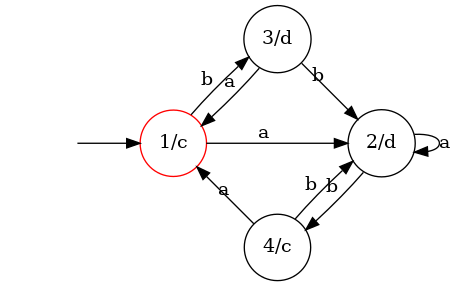
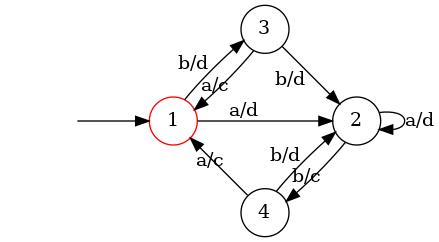

In [36]:
temp = MooreStateMachine('ab', 'dc', range(1,5), l_func = {
    1:'c',2:'d',3:'d',4:'c'
}, d_func = {
    (1, 'a'):2,
    (1, 'b'):3,
    (2, 'a'):2,
    (2, 'b'):4,
    (3, 'a'):1,
    (3, 'b'):2,
    (4, 'a'):1,
    (4, 'b'):2,
},start_state = 1)
temp2 = temp.to_mealy()
print(temp.get_table())
print(temp2.get_table())
draw(temp, temp2,width = 400, prog = 'circo')

In [37]:
def get_alpha():

    # States
    STATES = ['0', '1', '2', '3', '4']

    # Input alphabet
    INPUTS = ['a', 'b', 'c']

    # Output alphabet
    OUTPUTS = ['0', '1']

    # Output function: {(INPUT, STATE): OUTPUT}
    output_function = {
        ('0', 'a'): '0',
        ('0', 'b'): '1',
        ('0', 'c'): '0',
        ('1', 'a'): '1',
        ('1', 'b'): '0',
        ('1', 'c'): '1',
        ('2', 'a'): '0',
        ('2', 'b'): '0',
        ('2', 'c'): '1',
        ('3', 'a'): '1',
        ('3', 'b'): '0',
        ('3', 'c'): '1',
        ('4', 'a'): '1',
        ('4', 'b'): '1',
        ('4', 'c'): '0'
}

    # State change function: {(INPUT, STATE): NEXT_STATE}
    state_change_function = {
        ('0', 'a'): '1',
        ('0', 'b'): '2',
        ('0', 'c'): '0',
        ('1', 'a'): '2',
        ('1', 'b'): '3',
        ('1', 'c'): '2',
        ('2', 'a'): '3',
        ('2', 'b'): '0',
        ('2', 'c'): '4',
        ('3', 'a'): '4',
        ('3', 'b'): '0',
        ('3', 'c'): '3',
        ('4', 'a'): '0',
        ('4', 'b'): '1',
        ('4', 'c'): '2'}

    return MealyStateMachine(
        in_abc = ''.join(INPUTS),
        out_abc = ''.join(OUTPUTS),
        state_abc = STATES,
        l_func = output_function,
        d_func = state_change_function,
        start_state = STATES[0]
    )

def get_beta():
    # State Machine Definition

    # States
    STATES = ['A', 'B', 'C', 'D']

    # Input alphabet
    INPUTS = ['a', 'b', 'c']

    # Output alphabet
    OUTPUTS = ['0', '1']

    # Output function: {(INPUT, STATE): OUTPUT}
    output_function = {
        ('A', 'a'): '0',
        ('A', 'b'): '1',
        ('A', 'c'): '0',
        ('B', 'a'): '1',
        ('B', 'b'): '0',
        ('B', 'c'): '1',
        ('C', 'a'): '1',
        ('C', 'b'): '0',
        ('C', 'c'): '1',
        ('D', 'a'): '1',
        ('D', 'b'): '0',
        ('D', 'c'): '1'
}

    # State change function: {(INPUT, STATE): NEXT_STATE}
    state_change_function = {
        ('A', 'a'): 'A',
        ('A', 'b'): 'C',
        ('A', 'c'): 'B',
        ('B', 'a'): 'B',
        ('B', 'b'): 'A',
        ('B', 'c'): 'C',
        ('C', 'a'): 'A',
        ('C', 'b'): 'C',
        ('C', 'c'): 'D',
        ('D', 'a'): 'A',
        ('D', 'b'): 'C',
        ('D', 'c'): 'B'
}
    
    return MealyStateMachine(
        in_abc = ''.join(INPUTS),
        out_abc = ''.join(OUTPUTS),
        state_abc = STATES,
        l_func = output_function,
        d_func = state_change_function,
        start_state = STATES[0]
    )

In [38]:
def minimize_machine(machine: StateMachine):
    print("Минимизация конечного автомата")
    print(f'A = {(machine.in_abc)}')
    print(f'B = {(machine.out_abc)}')
    print(f'S = {(machine.state_abc)}')
    print(f'u0 = {machine.start_state}')
    minimalizer = machine.get_minimizer()
    minimal = minimalizer.get_minimal()
    print(machine.get_table().assign(**{'|':'|'}).join(minimalizer.get_table()))
    print("Разбиения (семейства классов):")
    n = len(minimalizer.get_all_klasses()) - 1
    j = None
    for i, k in enumerate(minimalizer.get_all_klasses()):
        if j is None and set(k.values()) == set(minimalizer.get_n_klasses(n).values()):
            j = i
        print(f'K{i} = {k}')
    print(f"Семейства классов K{n} неотличимы от K{j} => получено предельное разбиение.")
    print("Никакие слова произвольных длин не различат состояния в предельных классах.")
    print(f"Назовем их K = {minimalizer.get_n_klasses()}.")
    print('Интерпретируем эти классы как состояния минимального автомата.')
    print('Для получения функций минимального автомата берем любой представитель класса.')
    print('Упорядочим строки по списку классов и получаем минимальный автомат:')
    print(f'A = {(minimal.in_abc)}')
    print(f'B = {(minimal.out_abc)}')
    print(f'S = {(minimal.state_abc)}')
    print(f'u0 = {minimal.start_state}')
    print(minimal.get_table())
    draw(machine,minimal, width = 380, labels = ["Начальный автомат", "Минимальный автомат"])
    return minimalizer

In [39]:
def are_machines_equal(machine1: StateMachine, machine2: StateMachine):
    fused = machine1 | machine2
    print("Автомат alpha:")
    print(machine1.get_table())
    print()
    print("Автомат beta:")
    print(machine2.get_table())
    print()
    print("Автомат alpha * beta:")
    print(fused.get_table())
    print()
    if fused.get_table()['l'].all(None):
        print("Значения у всех пар выходной функции одинаковы, поэтому автоматы alpha и beta эквивалентны.")
    else:
        print("Значения пар выходной функции не везде одинаковы, поэтому автоматы alpha и beta не эквивалентны.")
    draw(machine1, machine2, width = "300", labels = ["alpha", 'beta'])
    draw(fused, width = "650", labels = ['alpha * beta'])
    return fused

Автомат alpha:
        l        d      
        a  b  c  a  b  c
states                  
0       0  1  0  1  2  0
1       1  0  1  2  3  2
2       0  0  1  3  0  4
3       1  0  1  4  0  3
4       1  1  0  0  1  2

Автомат beta:
        l        d      
        a  b  c  a  b  c
states                  
A       0  1  0  A  C  B
B       1  0  1  B  A  C
C       1  0  1  A  C  D
D       1  0  1  A  C  B

Автомат alpha * beta:
             l                       d                
             a       b       c       a       b       c
states                                                
(0, A)  (0, 0)  (1, 1)  (0, 0)  (1, A)  (2, C)  (0, B)
(1, A)  (1, 0)  (0, 1)  (1, 0)  (2, A)  (3, C)  (2, B)
(2, A)  (0, 0)  (0, 1)  (1, 0)  (3, A)  (0, C)  (4, B)
(3, A)  (1, 0)  (0, 1)  (1, 0)  (4, A)  (0, C)  (3, B)
(4, A)  (1, 0)  (1, 1)  (0, 0)  (0, A)  (1, C)  (2, B)
(0, B)  (0, 1)  (1, 0)  (0, 1)  (1, B)  (2, A)  (0, C)
(1, B)  (1, 1)  (0, 0)  (1, 1)  (2, B)  (3, A)  (2, C)
(2, B)  (0, 1)  (0, 0)


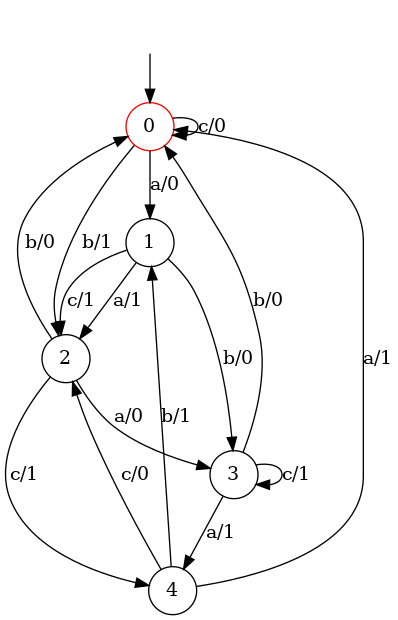
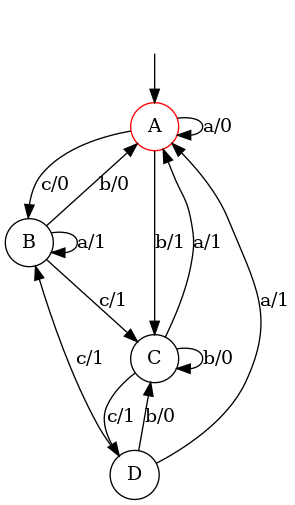


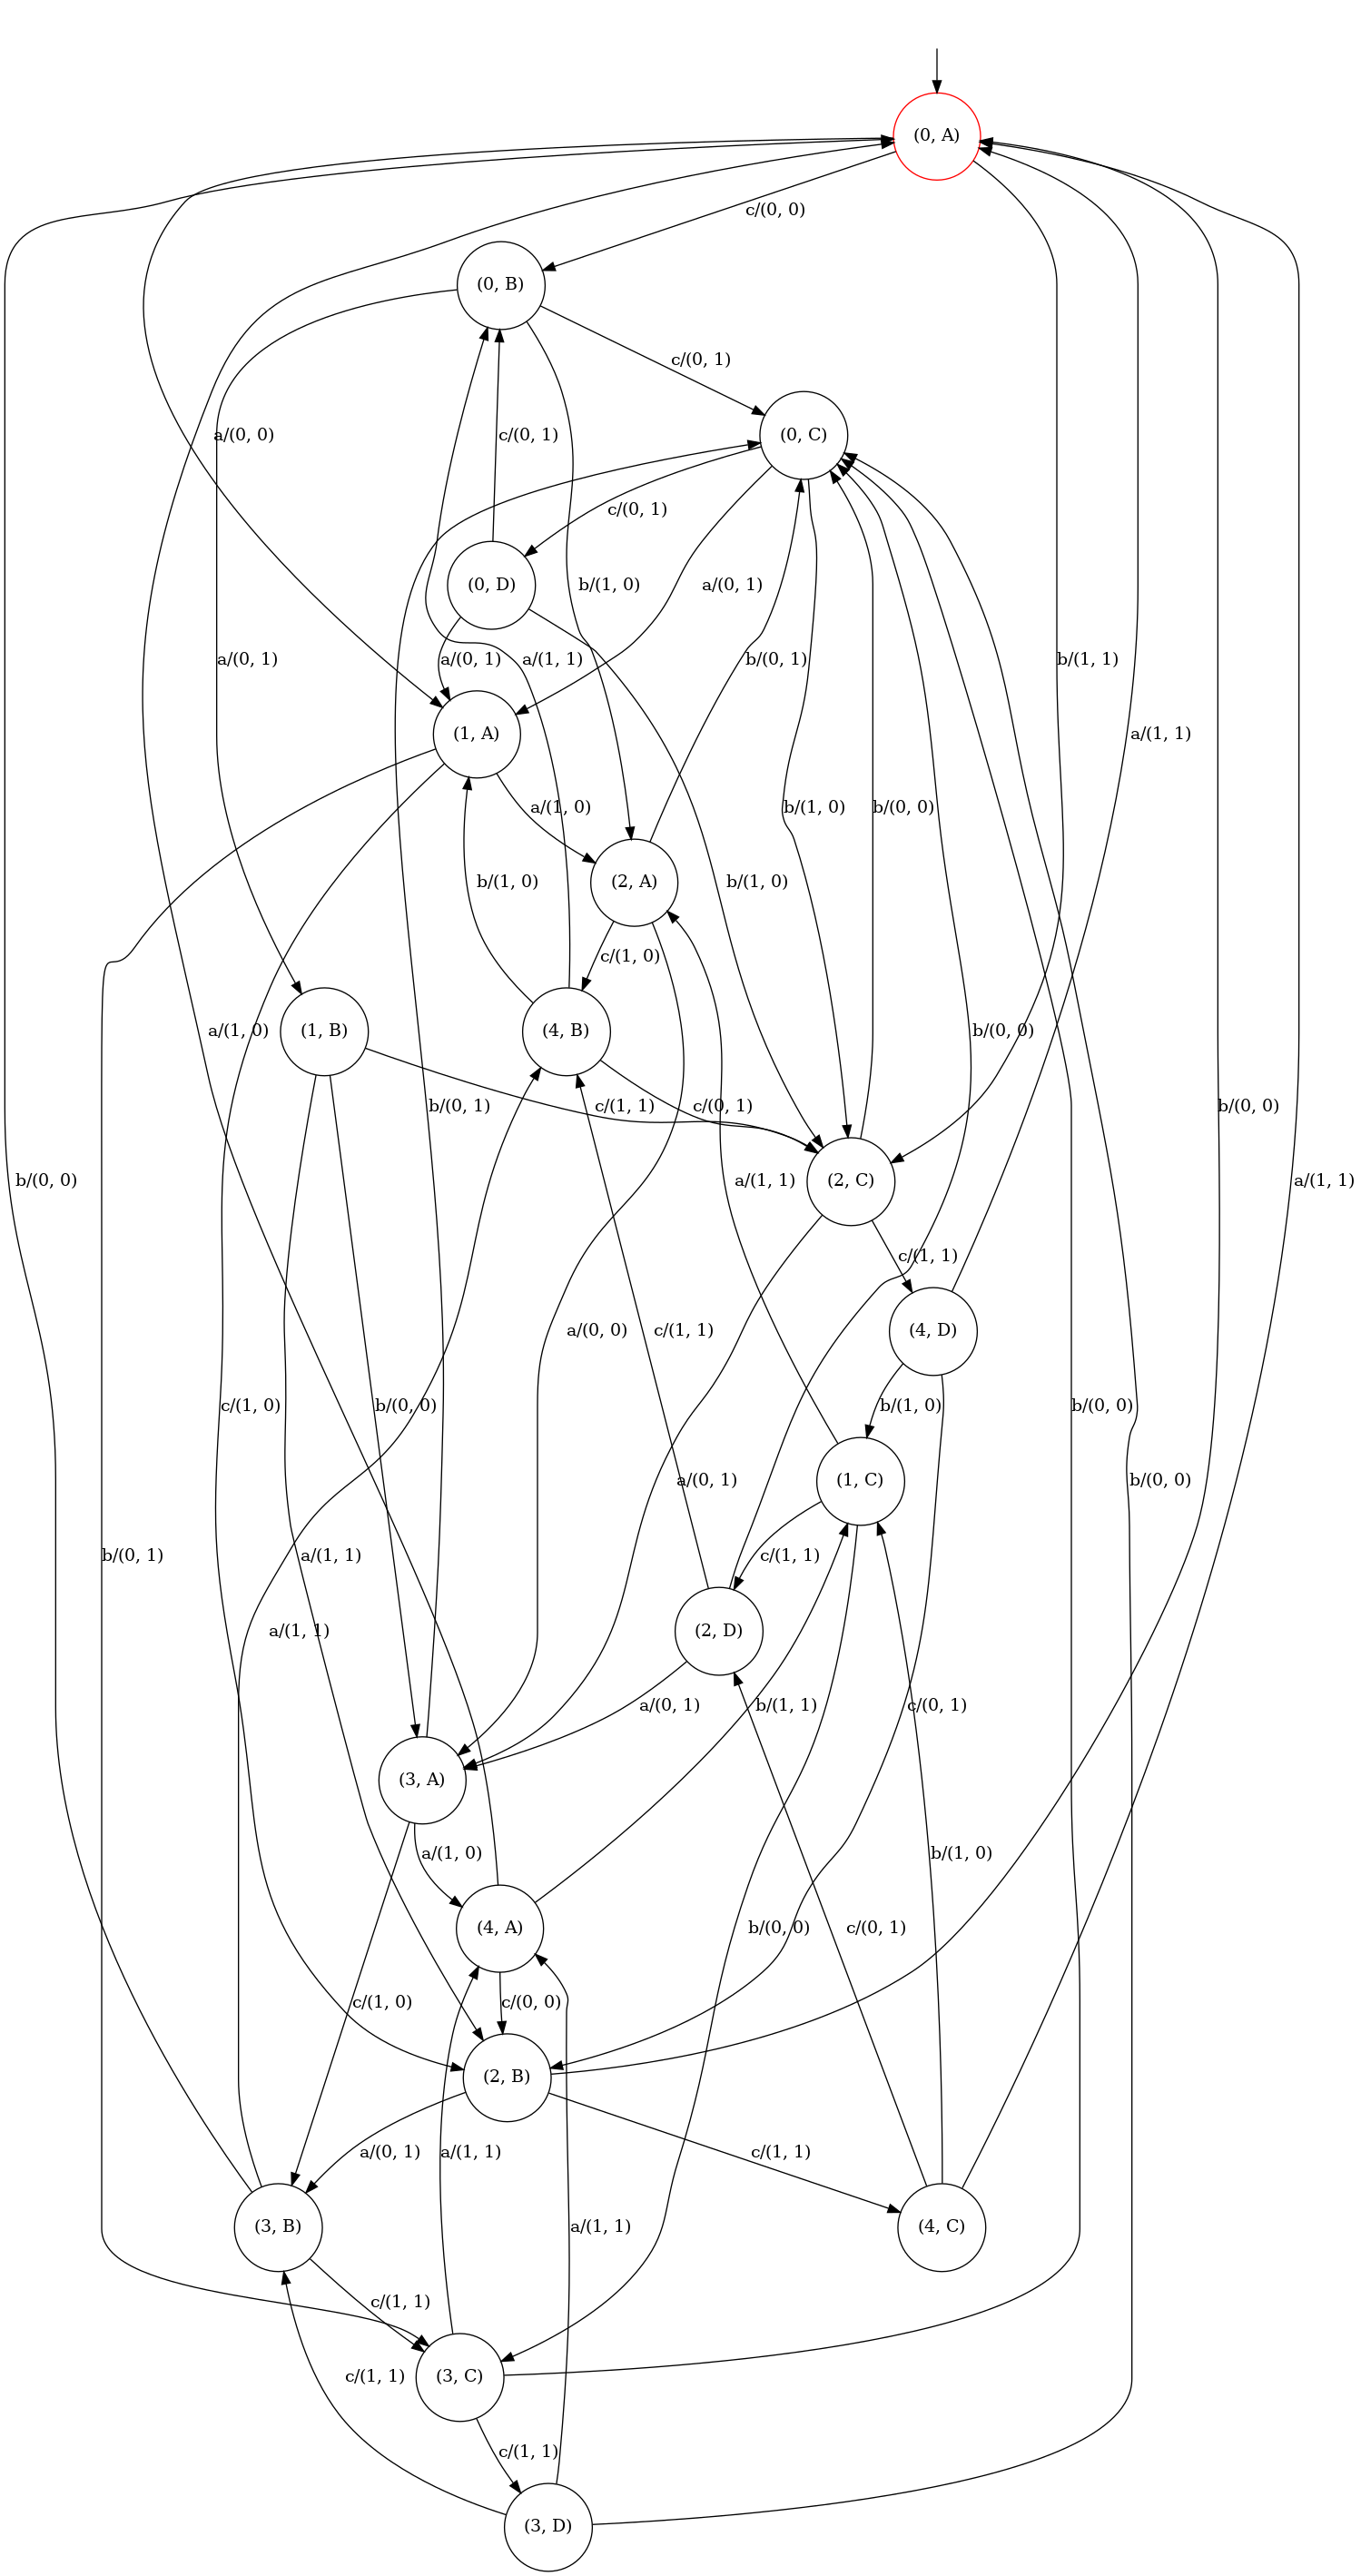

In [40]:
def task1():
    alpha = get_alpha()
    beta = get_beta()
    are_machines_equal(alpha, beta)
task1()

Автомат alpha:
        l     d   
        a  b  a  b
states            
1       1  0  2  3
2       0  1  3  2
3       0  0  1  2

Автомат beta:
        l     d   
        a  b  a  b
states            
A       1  0  B  E
B       0  1  C  B
C       0  0  A  D
D       0  1  C  B
E       0  0  A  D

Автомат alpha * beta:
             l               d        
             a       b       a       b
states                                
(1, A)  (1, 1)  (0, 0)  (2, B)  (3, E)
(2, B)  (0, 0)  (1, 1)  (3, C)  (2, B)
(3, C)  (0, 0)  (0, 0)  (1, A)  (2, D)
(2, D)  (0, 0)  (1, 1)  (3, C)  (2, B)
(3, E)  (0, 0)  (0, 0)  (1, A)  (2, D)

Значения у всех пар выходной функции одинаковы, поэтому автоматы alpha и beta эквивалентны.



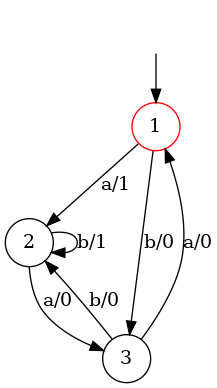
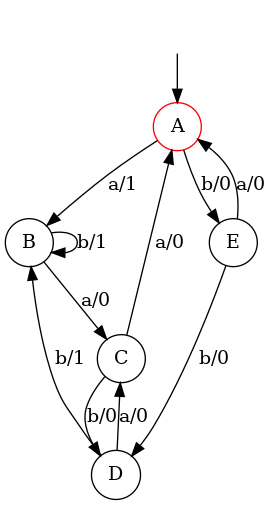


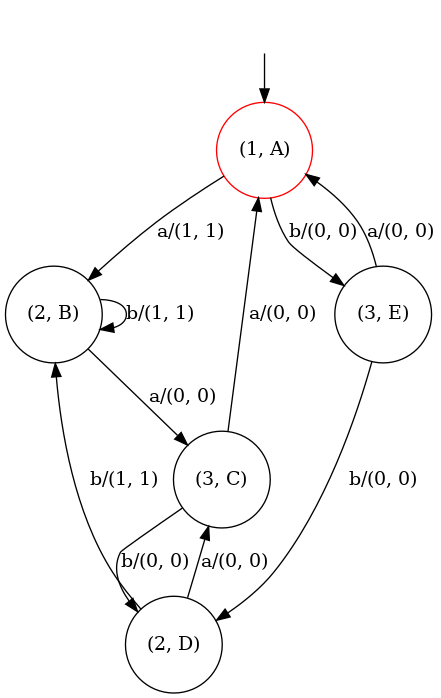

In [41]:
are_machines_equal(MealyStateMachine('ab',range(2),range(1,4),l_func = {
    (1, 'a'):1,
    (1, 'b'):0,
    (2, 'a'):0,
    (2, 'b'):1,
    (3, 'a'):0,
    (3, 'b'):0,
},d_func = {
    (1, 'a'):2,
    (1, 'b'):3,
    (2, 'a'):3,
    (2, 'b'):2,
    (3, 'a'):1,
    (3, 'b'):2,
},start_state = 1),MealyStateMachine('ab',range(2),'ABCDE',l_func = {
    ('A', 'a'):1,
    ('A', 'b'):0,
    ('B', 'a'):0,
    ('B', 'b'):1,
    ('C', 'a'):0,
    ('C', 'b'):0,
    ('D', 'a'):0,
    ('D', 'b'):1,
    ('E', 'a'):0,
    ('E', 'b'):0,
},d_func = {
    ('A', 'a'):'B',
    ('A', 'b'):'E',
    ('B', 'a'):'C',
    ('B', 'b'):'B',
    ('C', 'a'):'A',
    ('C', 'b'):'D',
    ('D', 'a'):'C',
    ('D', 'b'):'B',
    ('E', 'a'):'A',
    ('E', 'b'):'D',
},start_state = 'A'))


Минимизация конечного автомата
A = ('a', 'b')
B = ('0', '1')
S = ('1', '2', '3', '4', '5', '6', '7', '8')
u0 = 1
        l     d     |  d1      d2      d3      d4    
        a  b  a  b      a   b   a   b   a   b   a   b
states                                               
1       1  0  2  6  |  B1  A1  B2  A2  B3  E3  B4  E4
2       0  1  3  5  |  A1  B1  C2  B2  C3  D3  C4  D4
3       1  0  2  4  |  B1  B1  B2  B2  B3  D3  B4  D4
4       0  1  1  5  |  A1  B1  A2  B2  A3  D3  A4  D4
5       0  1  1  5  |  A1  B1  A2  B2  A3  D3  A4  D4
6       1  0  5  7  |  B1  A1  B2  D2  D3  F3  D4  F4
7       1  0  8  4  |  A1  B1  A2  B2  A3  D3  A4  D4
8       1  0  2  6  |  B1  A1  B2  A2  B3  E3  B4  E4
Разбиения (семейства классов):
K0 = {'A0': ('1', '2', '3', '4', '5', '6', '7', '8')}
K1 = {'A1': ('1', '3', '6', '7', '8'), 'B1': ('2', '4', '5')}
K2 = {'A2': ('1', '6', '8'), 'B2': ('2', '4', '5'), 'C2': ('3',), 'D2': ('7',)}
K3 = {'A3': ('1', '8'), 'B3': ('2',), 'C3': ('3',), 'D3': ('4', '5


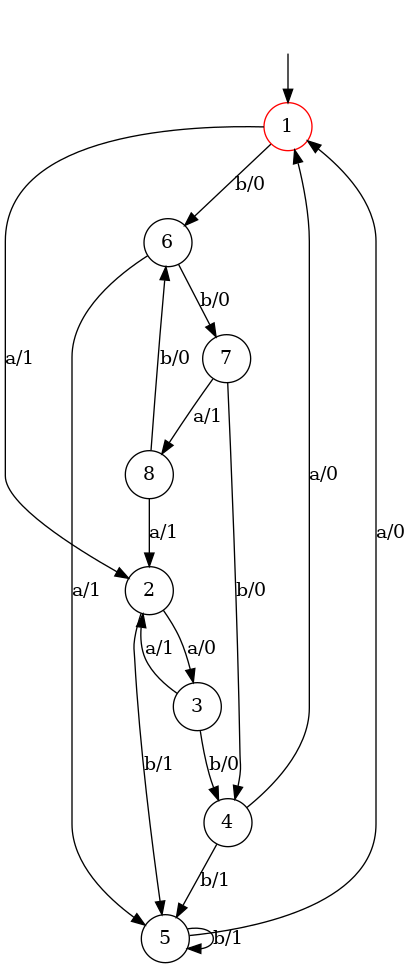
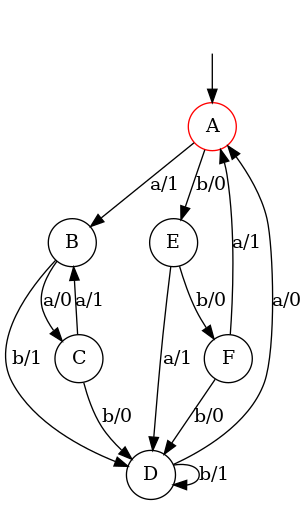

In [42]:
def task2():
    A = 'ab'
    B = {0,1}
    S = {1,2,3,4,5,6,7,8}
    l = {
        (1, 'a'): 1,
        (2, 'a'): 0,
        (3, 'a'): 1,
        (4, 'a'): 0,
        (5, 'a'): 0,
        (6, 'a'): 1,
        (7, 'a'): 1,
        (8, 'a'): 1,
        (1, 'b'): 0,
        (2, 'b'): 1,
        (3, 'b'): 0,
        (4, 'b'): 1,
        (5, 'b'): 1,
        (6, 'b'): 0,
        (7, 'b'): 0,
        (8, 'b'): 0,
    }

    d = {
        (1, 'a'): 2,
        (2, 'a'): 3,
        (3, 'a'): 2,
        (4, 'a'): 1,
        (5, 'a'): 1,
        (6, 'a'): 5,
        (7, 'a'): 8,
        (8, 'a'): 2,
        (1, 'b'): 6,
        (2, 'b'): 5,
        (3, 'b'): 4,
        (4, 'b'): 5,
        (5, 'b'): 5,
        (6, 'b'): 7,
        (7, 'b'): 4,
        (8, 'b'): 6,
    }
    u0 = 1
    automat = MealyStateMachine(A,B,S,l,d,u0)
    minimalizer = minimize_machine(automat)
    return automat, minimalizer

a1, a2 = task2()



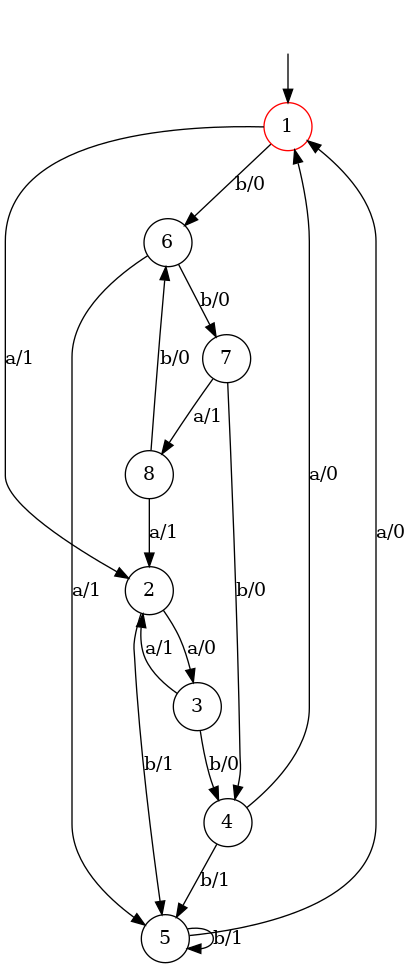
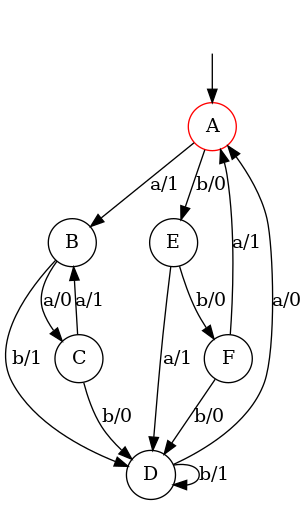
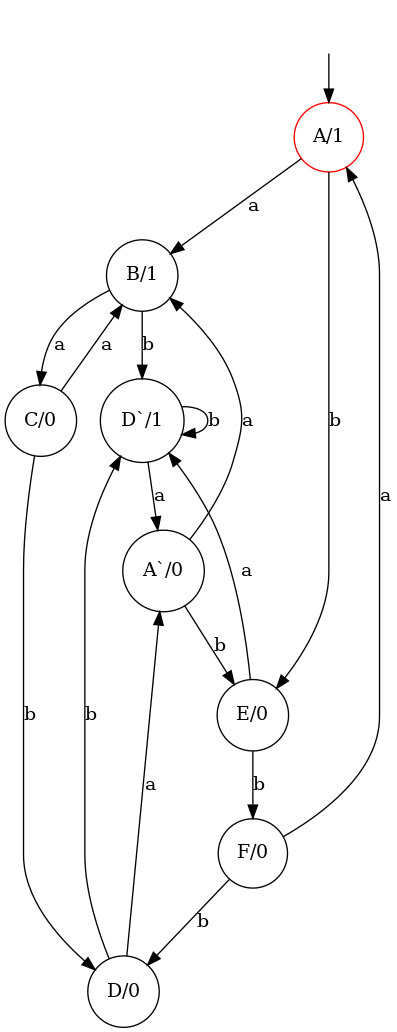

In [43]:
temp1 = a2.minimized_machine.to_moore()
# print(a2.minimized_machine.get_graph())
# print(temp1.get_graph())
# pprint(temp1.l_func)
# pprint(temp1.d_func)
# draw(a2.minimized_machine,width=300)
# draw(temp1, width=300)
draw(a1, a2.minimized_machine, temp1, width=250)


        l     d   
        a  b  a  b
states            
A       d  d  B  C
B       d  c  B  C
C       c  d  A  B
A
1



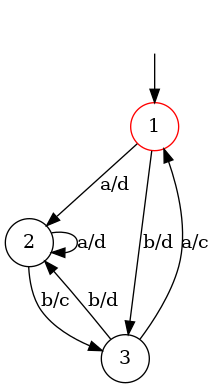
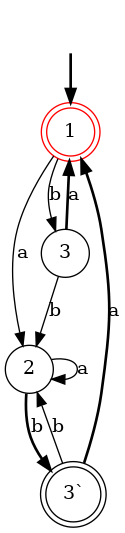
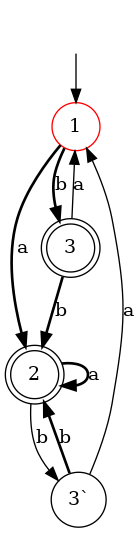
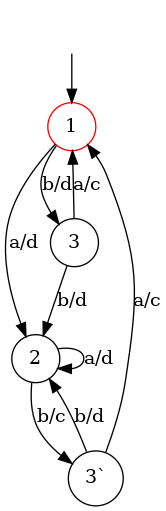
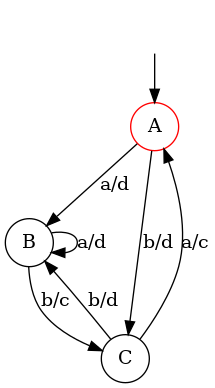

In [44]:
def test_to_moore():
    mealy = MealyStateMachine(
    in_abc='ab', out_abc='cd',state_abc=(1,2,3),start_state=1,
    l_func={
        (1,'a'):'d',
        (1,'b'):'d',
        (2,'a'):'d',
        (2,'b'):'c',
        (3,'a'):'c',
        (3,'b'):'d',
    },d_func={
        (1,'a'):2,
        (1,'b'):3,
        (2,'a'):2,
        (2,'b'):3,
        (3,'a'):1,
        (3,'b'):2,
    })
    
    moore = mealy.to_moore()
    new_mealy = moore.to_mealy()
    min_mealy = new_mealy.get_minimizer().get_minimal()
    print(min_mealy.get_table())
    print(min_mealy.start_state)
    print(new_mealy.start_state)
    draw(mealy, moore.get_graph('c'), moore.get_graph('d'), new_mealy, min_mealy,width=180)
test_to_moore()

Построение детерминированного автомат из недетерминированного.
Начальные вершины: ('2', '4')
                   a          b
-                              
(4, 2)        (5, 1)     (4, 2)
(5, 1)        (2, 1)     (4, 3)
(2, 1)        (2, 1)  (4, 3, 2)
(4, 3)        (4, 5)         ()
(4, 3, 2)  (4, 5, 1)     (4, 2)
(4, 5)           (5)        (4)
()                ()         ()
(4, 5, 1)  (5, 2, 1)     (4, 3)
(5)               ()        (4)
(4)              (5)         ()
(5, 2, 1)     (2, 1)  (4, 3, 2)
Переименуем множества в состояния.
{'A': ('4', '2'),
 'B': ('5', '1'),
 'C': ('2', '1'),
 'D': ('4', '3'),
 'E': ('4', '3', '2'),
 'F': ('4', '5'),
 'G': (),
 'H': ('4', '5', '1'),
 'I': ('5',),
 'J': ('4',),
 'K': ('5', '2', '1')}
и укажем функцию выхода: λ=1 у тех множеств, которые содержат финальные вершины исходной диаграммы (('3', '4'))

Построенный детерминированный автомат:
u0 = A
        d     l
        a  b  -
states         
A       B  A  1
B       C  D  0
C       C  E  0
D   


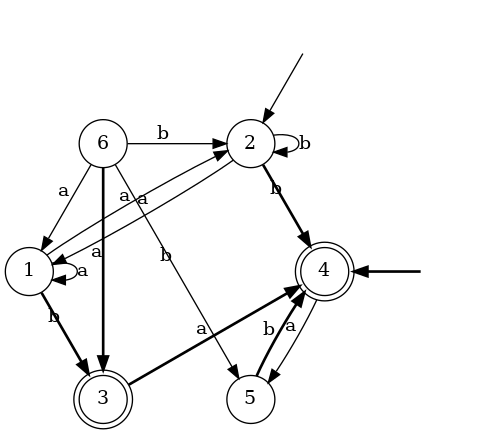
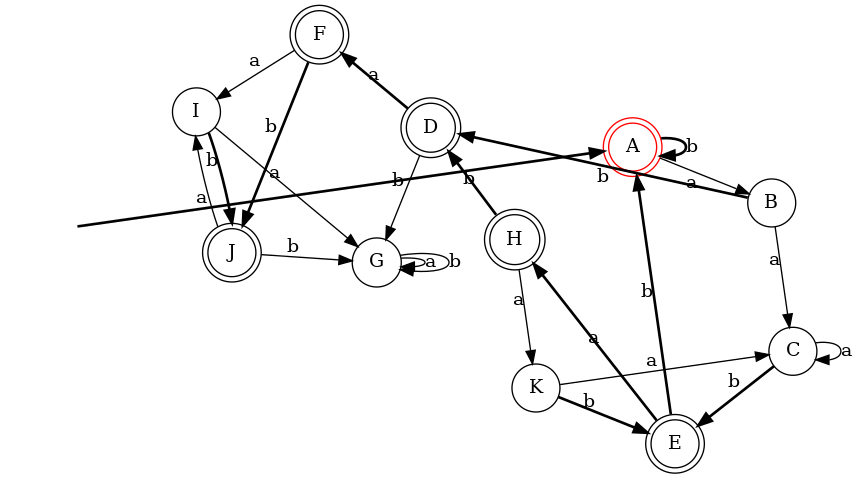

In [45]:
def task3():
    temp = Undetermined(
    in_abc='ab',
    start_states={2, 4},
    state_abc={1, 2, 3, 4, 5, 6},
    fin_states={3, 4},
    d_func={
        (1,'a'): {1, 2},
        (1,'b'): {3},
        
        (2,'a'): {1},
        (2,'b'): {2, 4},
        
        (3,'a'): {4},
        
        (4,'a'): {5},
        
        (5,'b'): {4},
        
        (6,'a'): {1, 3},
        (6,'b'): {2, 5},
    }
)
    print('Построение детерминированного автомат из недетерминированного.')
    print(f'Начальные вершины: {tuple(temp.start_states)}')
    g, m = temp.get_g_and_m()
    pprint(temp.get_table())
    print('Переименуем множества в состояния.')
    pprint({abc[i]: tuple(states) for i, states in enumerate(m)})
    print(f'и укажем функцию выхода: λ=1 у тех множеств, которые содержат финальные вершины исходной диаграммы ({tuple(temp.fin_states)})')
    print()
    print('Построенный детерминированный автомат:')
    moore = temp.to_moore()
    print(f'u0 = {moore.start_state}')
    pprint(moore.get_table())
    draw(temp, moore.get_graph('1'), width=400, prog='circo')
task3()


({(frozenset(), 'a'): frozenset(),
  (frozenset(), 'b'): frozenset(),
  (frozenset({'3'}), 'a'): frozenset(),
  (frozenset({'3'}), 'b'): frozenset({'2'}),
  (frozenset({'3', '1'}), 'a'): frozenset({'3', '2'}),
  (frozenset({'3', '1'}), 'b'): frozenset({'2'}),
  (frozenset({'2'}), 'a'): frozenset({'1'}),
  (frozenset({'2'}), 'b'): frozenset({'4'}),
  (frozenset({'3', '2'}), 'a'): frozenset({'1'}),
  (frozenset({'3', '2'}), 'b'): frozenset({'4', '2'}),
  (frozenset({'1'}), 'a'): frozenset({'3', '2'}),
  (frozenset({'1'}), 'b'): frozenset(),
  (frozenset({'4'}), 'a'): frozenset({'3'}),
  (frozenset({'4'}), 'b'): frozenset(),
  (frozenset({'4', '2'}), 'a'): frozenset({'3', '1'}),
  (frozenset({'4', '2'}), 'b'): frozenset({'4'})},
 [frozenset({'3', '1'}),
  frozenset({'3', '2'}),
  frozenset({'2'}),
  frozenset({'1'}),
  frozenset({'4', '2'}),
  frozenset({'4'}),
  frozenset(),
  frozenset({'3'})])
             a       b
-                     
(3, 1)  (3, 2)     (2)
(3, 2)     (1)  (4, 2)
(


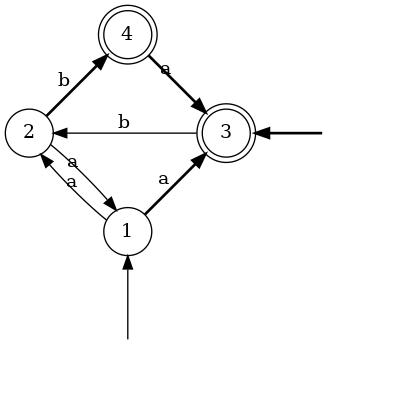

        d     l
        a  b  -
states         
A       B  C  1
B       D  E  1
C       D  F  0
D       B  G  0
E       A  F  1
F       H  G  1
G       G  G  0
H       G  C  1



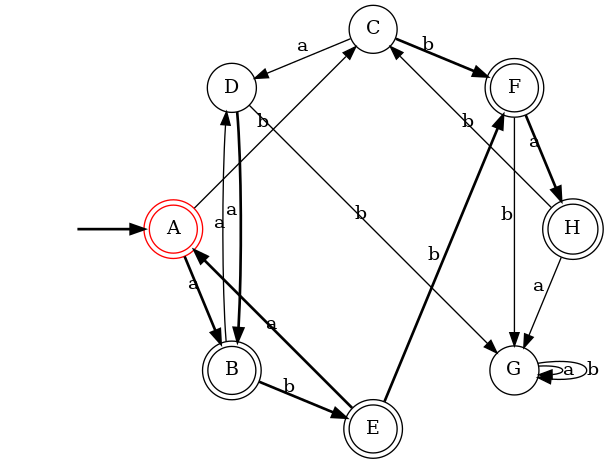


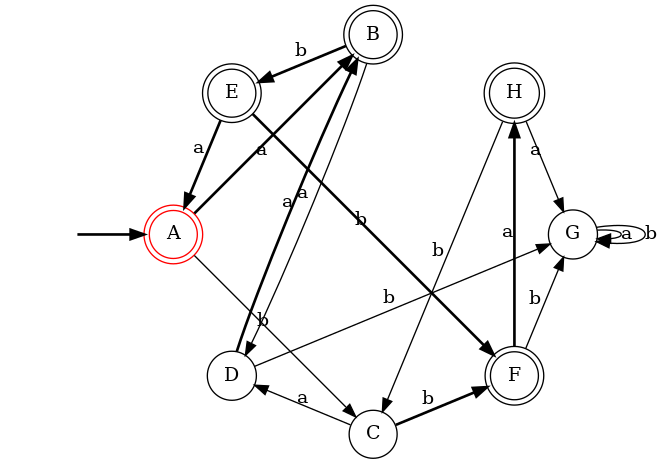

In [46]:
temp = Undetermined(
    in_abc='ab',
    start_states={1, 3},
    state_abc={1, 2, 3, 4},
    fin_states={3, 4},
    d_func={
        (1, 'a'): {2, 3},
        (2, 'a'): {1},
        (2, 'b'): {4},
        (3, 'b'): {2},
        (4, 'a'): {3},
    }
)
pprint(temp.get_g_and_m())
pprint(temp.get_table())
pprint(temp.in_abc)
pprint(temp.state_abc)
pprint(temp.start_states)
pprint(temp.fin_states)
pprint(temp.d_func)
draw(temp,width=400, prog='circo')
temp1 = temp.to_moore()
pprint(temp1.get_table())
draw(temp1.get_graph('1'),width=400, prog='circo')
temp2 = temp1.get_minimizer().get_minimal()
draw(temp2.get_graph('1'),width=400, labels = ['lal'], prog='circo')
